<a href="https://colab.research.google.com/github/hooked-on-mas/AutoGenBook/blob/multi-language/AutoGenBookCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 制定规格

输入以下内容后，按【执行所有单元格（Ctrl + F9）】。

In [1]:
# @markdown ## 必填项
# @markdown ### 教科书内容
book_content = "与机器学习相关的线性代数教科书" #@param {type:"string"}
# @markdown ### 大致页数
n_pages = 40 # @param {"type":"integer","placeholder":"40"}
# @markdown ### 输出格式
tex_output = True #@param {type:"boolean"}
pdf_output = True #@param {type:"boolean"}
md_output = True #@param {type:"boolean"}

# @markdown ## 可选项
# @markdown ### 预期读者群
target_readers = "已经熟悉Python和Numpy，今年开始研究机器学习的大四学生。" #@param {type:"string"}
# @markdown ### 数学公式的出现频率
equation_frequency_level = 4 #@param {type:"slider", min:1, max:5, step:1}
# @markdown ### 输出内容时考虑章节结构
do_consider_outline = True #@param {type:"boolean"}
# @markdown ### 输出内容时考虑之前的内容
do_consider_previous_sections = True #@param {type:"boolean"}
# @markdown ### 内容的其他要求
additional_requirements = "在解释理论之后，请加入使用Numpy进行计算的示例。" #@param {type:"string"}

if book_content == "":
    print('\033[31m'+'请指定教科书的内容。'+'\033[0m')
if n_pages == 0:
    print('\033[31m'+'请指定页数。'+'\033[0m')

## 定义提示词

In [2]:
# 公共提示
prompt_common = f"""
根据以下内容撰写书籍。
{book_content}
全书共{n_pages}页，每页预设40行。
"""
if target_readers != "":
    prompt_common += f"假定的读者对象如下所示：\n {target_readers}"
if additional_requirements != "":
    prompt_common += f"此外，请考虑以下事项：\n {additional_requirements}"

# 书籍和章节标题以及概要生成的提示
prompt_book_title = prompt_common + """
基于以上内容，请按如下json格式展示书籍和章节的标题、概要。
书籍概要不仅要包括内容概要，还要涉及书籍的主要目的、涵盖内容的范围和深度等，约5到10句详尽描述。
此外，请考虑每章应分配的页数，以0.1单位表示，如0.8页。
还需基于内容的语义凝聚性考虑每章是否需要细分（needsSubdivision），用true或false作答。
请勿包含推测或未经确认的信息，且标题中不需写明章节编号。
节的数量可根据需要进行调整。
```json
{{"title": "",
"summary": "",
"childs":
    [{{"title": "",
    "summary": "",
    "n_pages": ,
    "needsSubdivision":
    }},
    {{"title": "",
    "summary": "",
    "n_pages": ,
    "needsSubdivision":
    }},
    {{"title": "",
    "summary": "",
    "n_pages": ,
    "needsSubdivision":
    }}]
}}
```
"""

# 分节生成的提示
prompt_section_list_creation = prompt_common + """
基于以上信息，我打算以{book_title}为书名创建书籍。书籍概要如下。
{book_summary}
其中的{target}部分计划制作{n_pages}页，每页预设40行。
该部分的概要如下。
{section_summary}
请将该部分细分为多个部分，并输出每部分的标题和概要，格式如下json。
另外，请考虑每部分应分配的页数，以0.1单位表示，如0.8页。
还需基于内容的语义凝聚性考虑每部分是否需要进一步细分（needsSubdivision），用true或false作答。
请勿在标题中写明章节或节的编号。
```json
[{{"title": "",
"summary": "",
"n_pages": ,
"needsSubdivision":
}},
{{"title": "",
"summary": "",
"n_pages": ,
"needsSubdivision":
}}]
```
"""

# 本文内容生成的提示
prompt_content_creation = prompt_common + """
基于以上信息，我打算以{book_title}为书名创建书籍。书籍概要如下。
{book_summary}
其中的{target}部分计划制作{n_pages}页，每页预设40行。
该部分的概要如下。
{section_summary}
{toc_and_summary}
{previous_sections}
请用LaTeX输出该部分的内容，共{n_pages}页，即{n_pages} × 40行。
已在导言区引入所需的所有库。
请勿包含推测或未经确认的信息，不需包括标题，只需输出正文。
{equation_frequency}
请使用equation或align环境表示公式，避免使用其他环境。
避免嵌套公式，例如使用\\begin{{align}} \\end{{align}}，而非\\[ \\begin{{align}} \\end{{align}} \\]。
如需输出代码，请使用lstlisting环境，仅设置编程语言选项。例如，使用Python时应写为\\begin{{lstlisting}}[language=Python]。
在需要使用#时请确保使用\#进行转义。
输出格式如下：
```tex
本文内容
```
"""

## 设置参数

In [3]:
# 参数
max_depth = 5 # 1表示仅限节，2表示包括小节……
max_output_pages = 1.5 # LLM的最大输出页数

book_node_name = "book" # 根节点的名称

openai_api_secret_key_name = 'openai_api' # 注册openai_api为密钥时的变量名称
model_name = "gpt-4o" # 模型名称

if do_consider_previous_sections:
    n_previous_sections = 1
else:
    n_previous_sections = 0

## 安装和导入库

In [4]:
!apt-get update
!apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config
!apt-get install -y latexmk
!apt-get install -y texlive-latex-extra
!apt-get install -y texlive-luatex
!apt-get install -y texlive-bibtex-extra biber texlive-fonts-recommended
!apt-get install -y texlive-lang-chinese
!apt-get install -y texlive-science
%pip install -qU langchain-openai
%pip install pygraphviz
%pip install pylatex

import os
import re
import json
import networkx as nx
from google.colab import userdata
from IPython.display import Markdown
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional

import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

from pylatex import Command, Document, Section, Subsection, Package
from pylatex.section import Chapter
from pylatex.utils import NoEscape

from google.colab import files

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Ign:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:11 https://r2u.stat.illinois.edu/ubuntu jammy Release
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pack

## 创建图表

In [5]:
book_graph = nx.DiGraph(book_content=book_content, target_readers=target_readers, equation_frequency_level=equation_frequency_level, additional_requirements=additional_requirements)

## 创建标题和各章

### 定义函数

In [6]:
def extract_book_and_chapter_contents(markdown_text):
    """
    从Markdown格式的文本中提取第一个找到的JSON数据，并将其转换为Python字典类型返回的函数。

    参数:
        markdown_text (str): Markdown格式的字符串。假设该字符串中包含JSON格式的数据。

    返回:
        dict or None: 如果找到正确格式的JSON，则以字典类型返回；如果未找到或解析失败，则返回None。
    """

    # 从Markdown中找到JSON的起始点
    start_index = markdown_text.find('{')
    if start_index == -1:
        return None

    # 遍历整个字符串，检查嵌套的大括号平衡
    brace_count = 0
    for i in range(start_index, len(markdown_text)):
        if markdown_text[i] == '{':
            brace_count += 1
        elif markdown_text[i] == '}':
            brace_count -= 1

        # 当大括号平衡时提取JSON字符串
        if brace_count == 0:
            json_string = markdown_text[start_index:i+1]
            try:
                # 转换为JSON格式
                json_data = json.loads(json_string)
                return json_data
            except json.JSONDecodeError as e:
                print(f"JSON解析错误: {e}")
                return None
            return

    # 如果未找到闭合的大括号
    return None

### 由LLM生成输出

In [7]:
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = userdata.get(openai_api_secret_key_name)

llm = ChatOpenAI(model="gpt-4o")

prompt = PromptTemplate.from_template(prompt_book_title)

chain = prompt | llm
result = chain.invoke(
    {
        "book_content": book_content,
        "target_readers": target_readers,
        "n_pages": n_pages,
        "additional_requirements": additional_requirements
    }
)

book_json = extract_book_and_chapter_contents(result.content)

### 将结果存储到图表中

In [8]:
# 关于书籍
book_graph.add_nodes_from([(book_node_name, {"title": book_json["title"], "summary": book_json["summary"], "n_pages": n_pages, "needsSubdivision": True})])

# 关于章节（部分）
book_graph.add_nodes_from([(str(idx+1), child) for idx, child in enumerate(book_json["childs"])])
book_graph.add_edges_from([(book_node_name, str(idx+1)) for idx in range(len(book_json["childs"]))])

## 确认标题和结构

### 显示标题和结构

In [9]:
book_node = book_graph.nodes[book_node_name]

content_md = ""
content_md += "\n ## 标题：" + book_node["title"] + "（页数：" + str(book_node["n_pages"]) + "）"
content_md += "\n " + book_node["summary"]
for idx, child_node_name in enumerate(book_graph.successors(book_node_name)):
    child_node = book_graph.nodes[child_node_name]
    content_md += "\n ### 第" + str(idx+1) + "章：" + child_node["title"] + "（页数：" + str(child_node["n_pages"]) + "）"
    content_md += "\n" + child_node["summary"]

Markdown(content_md)


 ## 标题：线性代数与机器学习：从理论到实践（页数：40）
 本书旨在为即将进入机器学习领域的大四学生提供一本简明而实用的线性代数教科书。读者已具备Python和Numpy的基础知识，这使得他们能够专注于理解线性代数理论及其在机器学习中的实际应用。本书涵盖了线性代数的基本概念，如向量、矩阵、行列式和特征值等，并通过Numpy展示了如何进行相应的计算。书中内容从理论到实践逐步深入，帮助读者建立起坚实的数学基础，为进一步研究机器学习算法奠定基础。
 ### 第1章：线性代数在机器学习中的重要性（页数：2.0）
介绍线性代数在机器学习中的角色和重要性，为后续章节的学习奠定基础。
 ### 第2章：向量与向量运算（页数：4.0）
讲解向量的定义、运算及其在机器学习中的应用，并提供Numpy实现示例。
 ### 第3章：矩阵及其基本运算（页数：5.0）
介绍矩阵的概念、基本运算及性质，并通过Numpy演示矩阵运算。
 ### 第4章：行列式与逆矩阵（页数：4.0）
探讨行列式的计算、性质及逆矩阵的概念，并展示如何使用Numpy进行计算。
 ### 第5章：特征值与特征向量（页数：4.0）
解释特征值和特征向量的定义及其在数据降维中的应用，附Numpy计算实例。
 ### 第6章：线性变换与矩阵分解（页数：5.0）
介绍线性变换的概念及常见的矩阵分解方法，如LU分解与QR分解，并提供Numpy示例。
 ### 第7章：范数与距离测量（页数：3.0）
讨论向量和矩阵的不同范数及其在测量距离中的应用，结合Numpy示例进行实操。
 ### 第8章：线性回归的线性代数背景（页数：4.0）
通过线性代数的视角分析线性回归模型，展示其解法背后的数学原理及Numpy实现。
 ### 第9章：奇异值分解及其在机器学习中的应用（页数：4.0）
介绍奇异值分解的基本原理及其在降维和数据压缩中的应用，提供Numpy代码示例。
 ### 第10章：总结与展望（页数：2.0）
总结书中内容，并展望线性代数在更高级机器学习算法中的潜在应用。

## 创建图表

### 定义函数

In [10]:
def extract_section_list(markdown_text):

    pattern = r'```json\s*(.*?)\s*```'
    match = re.search(pattern, markdown_text, re.DOTALL)

    if match:
        json_string = match.group(1)
        data = json.loads(json_string)
        return data
    else:
        print("未找到 JSON 数据。")
        return None

def extract_section_content(markdown_text):

    pattern = r'```tex\s*(.*?)\s*```'
    match = re.search(pattern, markdown_text, re.DOTALL)

    if match:
        tex_string = match.group(1)
        return tex_string
    else:
        print("未找到 TeX 数据。")
        return None

def get_equation_frequency(equation_frequency_level):
    if equation_frequency_level == 1:
        return "几乎不使用公式，所有概念都请用通俗易懂的语言解释。仅在绝对必要时使用最少的公式。"
    elif equation_frequency_level == 2:
        return "谨慎使用公式，主要通过文字进行解释。仅在必要时使用简单的公式。"
    elif equation_frequency_level == 3:
        return "请平衡公式与文字说明的使用。用公式表达重要的概念，其余内容用文字补充说明。"
    elif equation_frequency_level == 4:
        return "请积极使用公式，准确表达概念和关系。不过，重要的说明请用文字补充。"
    elif equation_frequency_level == 5:
        return "请最大限度地使用公式。尽可能多地用公式表达概念和关系。"

### 由LLM生成的章节结构输出

In [11]:
book_node = book_graph.nodes[book_node_name]
next_parent_list = [book_node_name]

for depth in range(max_depth):
    parent_list = next_parent_list
    next_parent_list = []
    for parent_node_name in parent_list:
        for _, child_node_name in enumerate(book_graph.successors(parent_node_name)):
            parant_node = book_graph.nodes[parent_node_name]
            child_node = book_graph.nodes[child_node_name]


            if (child_node["needsSubdivision"] or child_node["n_pages"] >= max_output_pages) and depth < max_depth-1:

                # 通过LLM的输出
                prompt = PromptTemplate.from_template(prompt_section_list_creation)
                chain = prompt | llm

                result = chain.invoke(
                    {
                        "book_title": book_node["title"],
                        "book_summary": book_node["summary"],
                        "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
                        "target": child_node["title"],
                        "n_pages": child_node["n_pages"],
                        "section_summary": child_node["summary"]
                    }
                )

                # 将输出转换为字典格式
                section_json = extract_section_list(result.content)

                # 创建图节点并存储结果
                book_graph.add_nodes_from([(child_node_name + "-" + str(idx+1), grandchild) for idx, grandchild in enumerate(section_json)])
                book_graph.add_edges_from([(child_node_name, child_node_name + "-" + str(idx+1)) for idx in range(len(section_json))])

               # 仅在进行分节时成为下一个父节点
                next_parent_list.append(child_node_name)

            elif not child_node["needsSubdivision"] or depth == max_depth-1:

                # 创建图节点并存储结果
                book_graph.add_nodes_from([(child_node_name + "-p", {"content_file_path": child_node_name + "-p.tex"})])
                book_graph.add_edges_from([(child_node_name, child_node_name + "-p")])

            else:
                print("Error: needsSubdivision attribute is not set")

### 正文内容输出

#### 函数定义

In [12]:
def extract_content_list(string_list):
    """
    该函数从输入的string_list中提取匹配特定模式（以'-p'结尾的数字和短划线组合）的字符串，并返回一个新列表。
    """
    pattern = r'(?:\d+-)*\d+-p'
    return [s for s in string_list if re.match(pattern, s)]

def custom_sort_key(s):
    """
    该函数将字符串s按数字部分进行分割，并将它们转换为整数列表。
    这样可以生成一个用于按数值顺序排序的自定义键。
    """
    parts = re.split(r'[-p]', s)
    return [int(part) for part in parts if part != '']

def sort_strings(string_list):
    """
    该函数使用custom_sort_key函数定义的自定义键对输入的string_list进行排序，并返回排序后的新列表。
    """
    sorted_strings = sorted(string_list, key=custom_sort_key)
    return sorted_strings

def sort_leaf_nodes(book_graph):
    """
    该函数根据特定模式从book_graph中提取叶节点，并按数值顺序排列后返回一个列表。

    参数:
    - book_graph: 具有字符串标签节点的图对象

    返回值:
    - sorted_content_str_list: 排序后的字符串列表
    """
    # 从book_graph的节点中提取匹配特定模式的字符串
    content_str_list = extract_content_list(list(book_graph.nodes))

    # 使用自定义键对提取的字符串列表进行排序
    sorted_content_str_list = sort_strings(content_str_list)

    return sorted_content_str_list

def generate_outline(book_graph, book_node_name):
    """
    输出章节结构的函数，用于生成正文输出时的章节结构。
    """

    toc_and_summary = "以下是章节结构。\n"

    # 对具有正文内容的节点（叶节点）进行排序
    sorted_content_str_list = sort_leaf_nodes(book_graph)

    # 创建目录
    toc_and_summary += "# " + book_graph.nodes[book_node_name]["title"] + "\n"
    toc_and_summary += book_graph.nodes[book_node_name]["summary"] + "\n"

    for heading_number_str in sorted_content_str_list:
        heading_number = custom_sort_key(heading_number_str)

        # 章
        if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
            node_name = "-".join(map(str, heading_number[0:1]))
            toc_and_summary += "## " + book_graph.nodes[node_name]["title"] + "\n"
            toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # 节
        if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
            node_name = "-".join(map(str, heading_number[0:2]))
            toc_and_summary += "### " + book_graph.nodes[node_name]["title"] + "\n"
            toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # 小节
        if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
            node_name = "-".join(map(str, heading_number[0:3]))
            toc_and_summary += "#### " + book_graph.nodes[node_name]["title"] + "\n"
            toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

    return toc_and_summary

def slide_list_with_new_title_and_content(title, content, original_list):
    # 创建一个滑动后的列表，将新的元素（标题和内容的字典）添加到第0位
    slid_list = [{"title": title, "content": content}] + original_list[:-1]
    return slid_list

def generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sectinos):

    prompt = ""

    for i in range(n_previous_sectinos):
        i_previous_section = previous_sections_content_list[i]
        title = i_previous_section["title"]
        content = i_previous_section["content"]
        prompt += f"第{i+1}个前面的部分标题是{title}，内容如下。\n{content}\n"

    return prompt

#### 正文输出

In [13]:
# 输出时考虑章节结构
toc_and_summary = ""
if do_consider_outline:
    toc_and_summary = generate_outline(book_graph, book_node_name)

# 初始化保存过去输出内容的字符串列表
previous_sections_content_list = [{"title": "", "content": ""} for i in range(n_previous_sections)]

# 依次排列包含正文内容的节点（叶子节点）
sorted_content_str_list = sort_leaf_nodes(book_graph)

# 添加正文
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    node_name = "-".join(map(str, heading_number))
    node = book_graph.nodes[node_name]

    # 通过LLM生成输出
    prompt = PromptTemplate.from_template(prompt_content_creation)
    chain = prompt | llm

    result = chain.invoke(
        {
            "book_title": book_node["title"],
            "book_summary": book_node["summary"],
            "toc_and_summary": toc_and_summary,
            "previous_sections": generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sections),
            "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
            "target": node["title"],
            "n_pages": node["n_pages"],
            "section_summary": node["summary"]
        }
    )

    # 将输出保存到文件
    contents_tex = extract_section_content(result.content)
    with open(node_name + "-p.tex", mode='w', encoding='UTF-8') as f:
        f.write(contents_tex)

    # 保存过去的输出内容
    if do_consider_previous_sections:
        previous_sections_content_list = slide_list_with_new_title_and_content(node["title"], contents_tex, previous_sections_content_list)

## 显示本书图表

从book出来的箭头指向章节点，下面是节节点，再下面是小节节点。
这些节点包含该章、节的标题或概要作为信息。
红色圆点表示的末端节点是包含正文内容信息的节点。


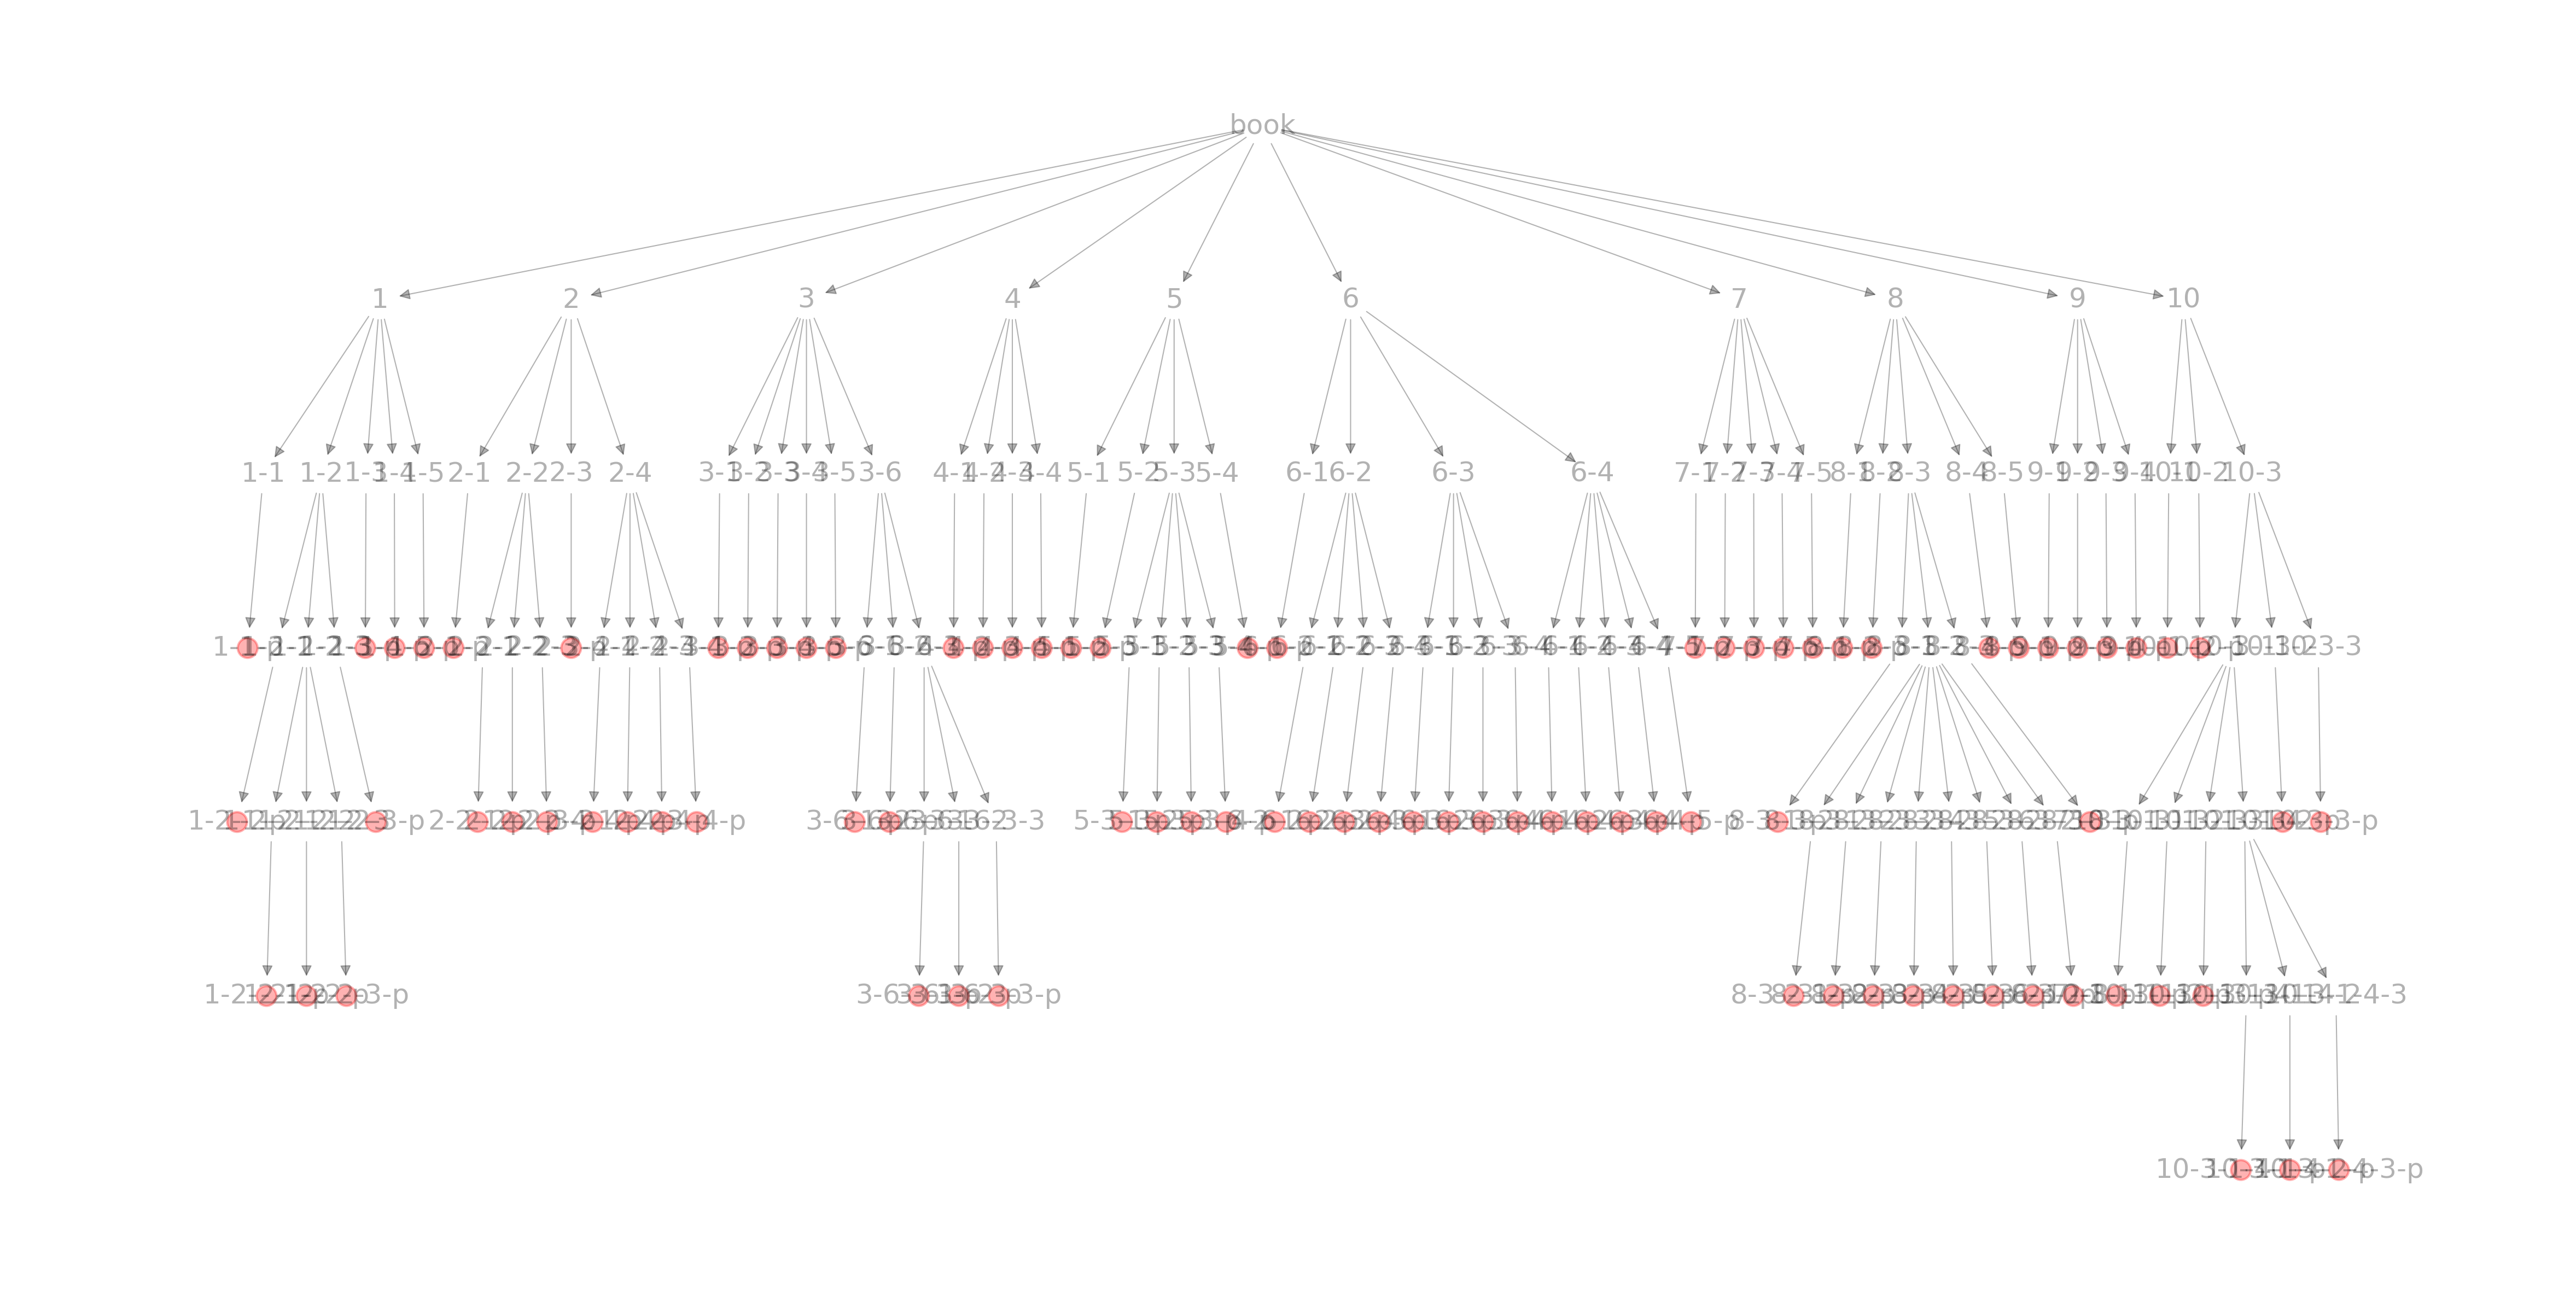

In [14]:
pos = graphviz_layout(book_graph, prog="dot")

# matplotlib settings
fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 1, 1)

# 将叶子节点（正文节点）设置为红色
node_color_list = ["r" if "p" in s else "w" for s in list(book_graph.nodes)]

# draw the network
nx.draw(book_graph,
        ax=ax,
        pos=pos,
        with_labels=True,
        node_size=300,
        node_color=node_color_list,
        alpha=0.3,
        node_shape='.',
        width=0.5)

print("从book出来的箭头指向章节点，下面是节节点，再下面是小节节点。\n这些节点包含该章、节的标题或概要作为信息。\n红色圆点表示的末端节点是包含正文内容信息的节点。")

## 创建书籍

### 创建latexmkrc文件

In [15]:
# 获取主目录的路径
home_dir = os.path.expanduser("~")

# 创建 .latexmkrc 文件的路径
latexmkrc_path = os.path.join(home_dir, ".latexmkrc")

# latexmkrc 文件的内容
content = '''$latex = 'lualatex -synctex=1 -halt-on-error -interaction=nonstopmode %O %S';
$bibtex = 'bibtex %O %S';
$biber = 'biber %O %S';
$makeindex = 'makeindex %O -o %D %S';
$dvipdf = 'dvipdfmx %O -o %D %S';

$max_repeat = 5;
$pdf_mode = 4;'''

# 创建文件并写入内容
try:
    with open(latexmkrc_path, "w") as file:
        file.write(content)
    print(f".latexmkrc 文件已成功创建于 {latexmkrc_path}")
except IOError as e:
    print(f"创建文件时发生错误: {e}")

.latexmkrc 文件已成功创建于 /root/.latexmkrc


### 使用LaTeX编写正文

### 创建LaTeX文档

In [16]:
# 使用pylatex生成PDF
geometry_options = {"tmargin": "3cm", "lmargin": "3cm"}
doc = Document(documentclass="report", geometry_options=geometry_options)

# 添加前言和标题
doc.packages.append(Package('ctex'))
doc.packages.append(Package('amsmath'))
doc.packages.append(Package('amssymb'))
doc.packages.append(Package('amsfonts'))
doc.packages.append(Package('mathtools'))
doc.packages.append(Package('bm'))
doc.packages.append(Package('physics'))
doc.packages.append(Package('inputenc', options="utf8"))
doc.packages.append(Package('listings'))
doc.packages.append(Package('jvlisting'))
doc.packages.append(Package('color'))
doc.packages.append(Package('underscore', options="strings"))
doc.preamble.append(Command("title", book_graph.nodes[book_node_name]["title"]))
doc.preamble.append(Command("date", NoEscape(r"\today")))
doc.append(NoEscape(r"\maketitle"))
doc.append(NoEscape(r"\tableofcontents"))
doc.append(NoEscape(r'\lstset{ backgroundcolor={\color[gray]{.90}}, breaklines = true, breakindent = 10pt, basicstyle = \ttfamily\scriptsize, commentstyle = {\itshape \color[cmyk]{1,0.4,1,0}}, classoffset = 0, keywordstyle = {\bfseries \color[cmyk]{0,1,0,0}}, stringstyle = {\ttfamily \color[rgb]{0,0,1}}, frame = TBrl, framesep = 5pt, numbers = left, stepnumber = 1, numberstyle = \tiny, tabsize = 4, captionpos = t}'))

In [17]:
# 按顺序排列包含正文内容的节点
content_str_list = extract_content_list(list(book_graph.nodes))
sorted_content_str_list = sort_strings(content_str_list)

# 添加正文内容
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    # 添加章节标题
    if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
        node_name = "-".join(map(str, heading_number[0:1]))
        with doc.create(Chapter(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # 添加节标题
    if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
        node_name = "-".join(map(str, heading_number[0:2]))
        with doc.create(Section(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # 添加小节标题
    if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
        node_name = "-".join(map(str, heading_number[0:3]))
        with doc.create(Subsection(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # 添加正文内容
    tex_file_path = book_graph.nodes[heading_number_str]["content_file_path"]
    with open(tex_file_path, "r", encoding='UTF-8') as file:
        tex_content = file.read()
        doc.append(NoEscape(tex_content))

### 创建PDF文件

In [18]:
# 编译。将创建 /content/textbook.pdf 文件
n_displayed_line = 10
isErrorOccured = False

try:
    doc.generate_pdf(book_node["title"], compiler="latexmk", clean_tex=False)
except:
    log_file_path = "/content/" + book_node["title"] + ".log"

    # 读取日志文件内容
    with open(log_file_path, "r", encoding="utf-8", errors="ignore") as file:
        lines = file.readlines()

    # 定义错误输出模式（file-line-error 选项格式）
    pattern = r'([a-zA-Z0-9_.]+):(\d+): (.+)'

    for i, line in enumerate(lines):
        match = re.search(pattern, line)
        if match:
            isErrorOccured = True
            print(f"行: {match.group(2)}")
            print(f"消息: \n  {match.group(3)}")
            for j in range(i+1, min(i+n_displayed_line, len(lines))):
                print(lines[j].strip())
            print("-" * 40)

if isErrorOccured:
    files.download("/content/" + book_node["title"] + ".tex")
    raise Exception("编译 TeX 文件时发生错误。请重新运行或参考上述错误内容，修正后再编译。")

In [19]:
# 下载
if tex_output:
    files.download("/content/" + book_node["title"] + ".tex")

if pdf_output:
    files.download("/content/" + book_node["title"] + ".pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 创建Markdown文件

In [20]:
def clean_markdown_content(content):
    # 删除标题前的部分（与LaTeX设置相关的部分）
    content = content.split('#', 1)[1]

    # 仅在前后有换行或空格的情况下，删除%
    content = re.sub(r"(?<=\s)%|%(?=\s)", "", content)

    # 仅删除出现在末尾的%
    content = re.sub(r"%\s*$", "", content)

    # 将多个换行替换为一个换行
    content = re.sub(r"\n{2,}", "\n\n", content)

    return content

def convert_to_latex_to_katex(content):
    # 转换align, align*环境
    content = re.sub(r'\\begin{align\*?}', r'$$\n\\begin{aligned}', content)
    content = re.sub(r'\\end{align\*?}', r'\\end{aligned}\n$$', content)

    # 转换equation, equation*环境
    content = re.sub(r'\\begin{equation\*?}', r'$$', content)
    content = re.sub(r'\\end{equation\*?}', r'$$', content)

    return content

def transform_code_blocks(content):

    # 处理language选项
    def replace_lstlisting(match):
        options = match.group(1)
        code = match.group(2)
        # 查找language选项
        lang_match = re.search(r'language=([a-zA-Z]+)', options)
        lang = lang_match.group(1) if lang_match else ''
        # 转换为Markdown格式
        return f'```{lang}\n{code}\n```'

    # lstlisting的转换处理
    content = re.sub(r'\\begin{lstlisting}\[(.*?)\](.*?)\\end{lstlisting}', replace_lstlisting, content, flags=re.DOTALL)

    return content

In [21]:
if md_output:
    %pip install latex2markdown
    import latex2markdown

    with open("/content/" + book_node["title"] + ".tex", "r") as f:
        latex_string = f.read()

    # 将LaTeX转换为Markdown
    processed_latex_str = transform_code_blocks(latex_string)
    l2m = latex2markdown.LaTeX2Markdown(processed_latex_str)
    markdown_string = l2m.to_markdown()

    # 格式化Markdown文本
    cleaned_md_str = clean_markdown_content(markdown_string)
    katex_md_str = convert_to_latex_to_katex(cleaned_md_str)

    with open("/content/" + book_node["title"] + ".md", "w") as f:
        f.write(katex_md_str)
    files.download("/content/" + book_node["title"] + ".md")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>